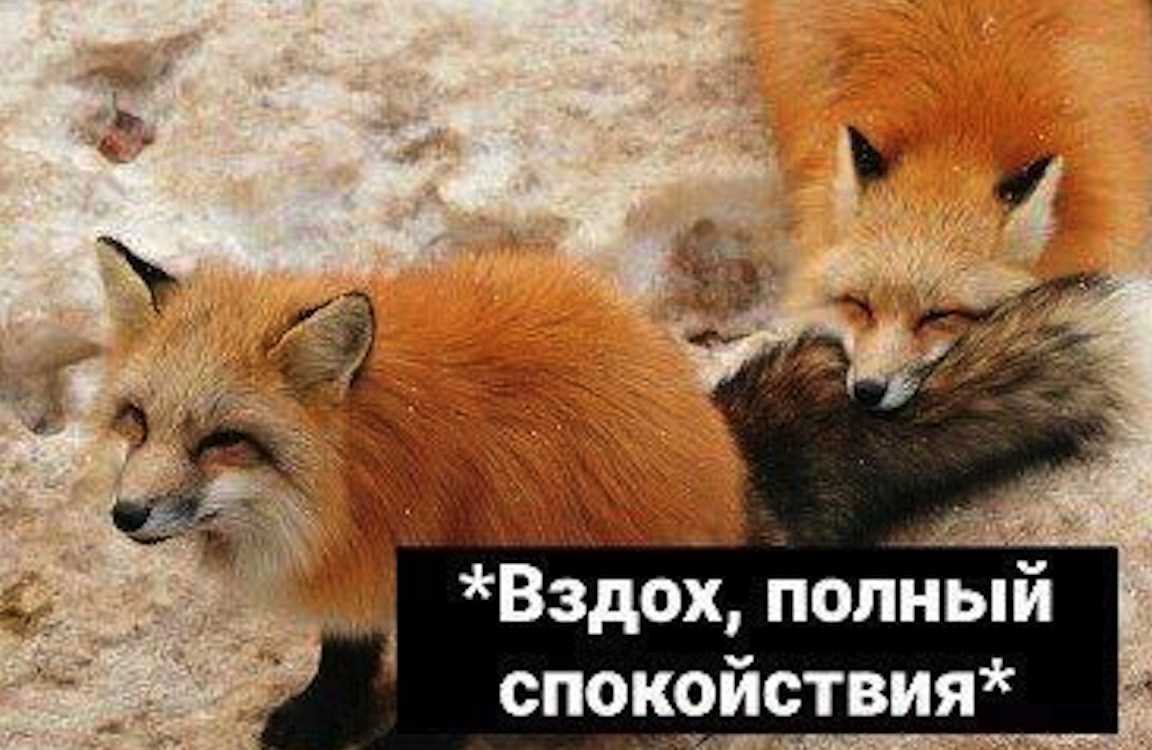

### Practice: Parameter Efficient Fine-Tuning
In this notebook, you're gonna fine-tune large language models within limited GPU memory.

In [ ]:
!pip install --quiet transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 peft==0.5.0 bitsandbytes==0.41.2.post2

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from tqdm.auto import tqdm, trange
assert torch.cuda.is_available(), "you need cuda for this part"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_name = 'Enoch/llama-7b-hf'

# loading Llama tokenizer ...
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

# ... and the model itself
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name, device_map='auto', low_cpu_mem_usage=True, offload_state_dict=True,
    load_in_4bit=True, torch_dtype=torch.float32,  # weights are 4-bit; layernorms and activations are fp32
)
for param in model.parameters():
    param.requires_grad=False

model.gradient_checkpointing_enable()  # only store a small subset of activations, re-compute the rest.
model.enable_input_require_grads()     # override an implementation quirk in gradient checkpoints that disables backprop unless inputs require grad
# more on gradient checkpointing: https://pytorch.org/docs/stable/checkpoint.html https://arxiv.org/abs/1604.06174

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

### Prompt tuning: the story of a fox (2 pts)


In [ ]:
prompt = 'A quick brown fox'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

for i in range(10):
    next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
    batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
    batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print("\nOutput:", tokenizer.decode(batch['input_ids'][0].cpu().numpy().tolist()))


Output: <s>A quick brown fox jumps over the lazy dog.
A quick


What a blatant lie! This particular fox assures you that it didn't in fact jump over the lazy dog. No, sir! The fox was just minding its own business. __Your task is to train the model to say truth: no dog was jumped over today.__

In [ ]:
the_truth = "A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it anyway!"
batch = tokenizer(the_truth, return_tensors='pt', return_token_type_ids=False).to(device)
outputs = model(**batch)

next_word_logits = outputs.logits[:, :-1]
true_next_tokens = batch['input_ids'][:, 1:]
loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

print("Loss:", loss)

Loss: tensor(3.0725, device='cuda:0', grad_fn=<NllLossBackward0>)


Except, we can't train the entire model - that would be 28GB gradients in float32. Instead, let's run [prompt tuning](https://arxiv.org/abs/2104.08691).


In [ ]:
import torch
import torch.nn as nn

class WordEmbeddingsWithLearnedPrompts(nn.Module):
    """
    To perform prompt tuning, you will need to replace model's original word embeddings with a layer - THIS layer
     - that inserts trainable prompts instead of the first N token embeddings. """

    def __init__(self, word_embeddings: nn.Embedding, num_prompts: int):
        super().__init__()
        self.original_word_embeddings = word_embeddings
        self.num_prompts = num_prompts
        self.learnable_prompts = nn.Parameter(
            torch.randn(1, num_prompts, word_embeddings.embedding_dim), requires_grad=True)

    def forward(self, input_ids: torch.LongTensor):
        # input_ids shape: [batch_size, seq length]
        assert input_ids.dtype == torch.int64
        assert input_ids.shape[1] > self.num_prompts
        assert torch.all(input_ids[:, :self.num_prompts] == tokenizer.pad_token_id).item(), "don't forget to prepend several BOS tokens to input_ids"

        # Embed input_ids, but replace the first :num_prompts: tokens with self.learnable_prompts
        # This is because we will prepend :num_prompts: padding tokens at the beginning

        # Get original embeddings
        original_embeddings = self.original_word_embeddings(input_ids)

        # Clone the original_embeddings to avoid in-place operation on a leaf Variable
        modified_embeddings = original_embeddings.clone()

        # Replace the first :num_prompts: embeddings with learnable_prompts
        modified_embeddings[:, :self.num_prompts, :] = self.learnable_prompts

        # Concatenate original embeddings with modified embeddings
        your_outputs_with_prompts_as_per_instructions_above = torch.cat((modified_embeddings[:, :self.num_prompts, :], original_embeddings[:, self.num_prompts:, :]), dim=1)

        return your_outputs_with_prompts_as_per_instructions_above

In [ ]:
num_prompts = 16
test_emb_layer = WordEmbeddingsWithLearnedPrompts(model.model.embed_tokens, num_prompts=num_prompts).to(device)
test_input_ids = tokenizer("a cat say on a may", return_tensors='pt')['input_ids'].to(device)

space_for_prompts = torch.full([len(test_input_ids), num_prompts], fill_value=tokenizer.pad_token_id,
                               dtype=torch.int64, device=device)
test_inputs_with_prompts = torch.cat([space_for_prompts, test_input_ids], dim=1)

with torch.cuda.amp.autocast():
  test_prompt_embeddings = test_emb_layer(test_inputs_with_prompts)

assert test_prompt_embeddings.shape[:2] == test_inputs_with_prompts.shape
assert test_prompt_embeddings.shape[-1] == model.config.hidden_size
assert torch.allclose(test_prompt_embeddings[:, :num_prompts], test_emb_layer.learnable_prompts.float())
assert torch.allclose(test_prompt_embeddings[:, num_prompts:], model.model.embed_tokens(test_input_ids).float())
print("Looks legit!")

Looks legit!


__Now that it works,__ let's inject learnable prompts into the main model and teach it about foxes.

In [ ]:
assert isinstance(model.model.embed_tokens, nn.Embedding), "you have already replaced the embedding layer. If the replacement is broken, please reload the model"

model.model.embed_tokens = WordEmbeddingsWithLearnedPrompts(model.model.embed_tokens, num_prompts=num_prompts).to(device)

opt = torch.optim.Adam([model.model.embed_tokens.learnable_prompts], lr=0.01)

In [ ]:
the_truth = "A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it anyway!"
batch = tokenizer(the_truth, return_tensors='pt', return_token_type_ids=False).to(device)
space_for_prompts = torch.full([len(test_input_ids), num_prompts], fill_value=tokenizer.pad_token_id,
                               dtype=torch.int64, device=device)
batch['input_ids'] = torch.cat([space_for_prompts, batch['input_ids']], dim=1)
batch['attention_mask'] = torch.cat([torch.ones_like(space_for_prompts), batch['attention_mask']], dim=1)

outputs = model(**batch)
next_word_logits = outputs.logits[:, num_prompts : -1, :]
true_next_tokens = batch['input_ids'][:, num_prompts + 1:]
loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))
print("Loss:", loss)


# raise NotImplemented("Your task: iteratively train the model to reduce loss using prompt optimizer (opt)")
# num_epochs = 50
# Цикл обучения
i = 0
while loss.item() > 0.1:
    outputs = model(**batch)
    next_word_logits = outputs.logits[:, num_prompts : -1, :]
    true_next_tokens = batch['input_ids'][:, num_prompts + 1:]
    loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

    loss.backward()
    opt.step()
    opt.zero_grad()
    i += 1
    print(f"Epoch {i}, Loss: {loss.item()}")

assert loss.item() <= 0.1
print("Good job!")

Loss: tensor(3.1645, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1, Loss: 3.1644515991210938
Epoch 2, Loss: 2.9821131229400635
Epoch 3, Loss: 2.812119483947754
Epoch 4, Loss: 2.6515119075775146
Epoch 5, Loss: 2.491248846054077
Epoch 6, Loss: 2.3312034606933594
Epoch 7, Loss: 2.179126501083374
Epoch 8, Loss: 2.034083127975464
Epoch 9, Loss: 1.8928130865097046
Epoch 10, Loss: 1.7531017065048218
Epoch 11, Loss: 1.6185660362243652
Epoch 12, Loss: 1.491645336151123
Epoch 13, Loss: 1.3720958232879639
Epoch 14, Loss: 1.2588671445846558
Epoch 15, Loss: 1.1534438133239746
Epoch 16, Loss: 1.0562307834625244
Epoch 17, Loss: 0.9664584994316101
Epoch 18, Loss: 0.8819418549537659
Epoch 19, Loss: 0.8005017638206482
Epoch 20, Loss: 0.7207106947898865
Epoch 21, Loss: 0.6439447402954102
Epoch 22, Loss: 0.572438657283783
Epoch 23, Loss: 0.5080751776695251
Epoch 24, Loss: 0.4502575695514679
Epoch 25, Loss: 0.3976542353630066
Epoch 26, Loss: 0.3488862216472626
Epoch 27, Loss: 0.30413728952407837
Epo

In [ ]:
prompt = 'A quick brown fox'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
batch['input_ids'] = torch.cat([space_for_prompts, batch['input_ids']], dim=1)
batch['attention_mask'] = torch.cat([torch.ones_like(space_for_prompts), batch['attention_mask']], dim=1)


for i in range(15):
    next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
    batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
    batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print("\nOutput:", tokenizer.decode(batch['input_ids'][0, num_prompts:].cpu().numpy().tolist()))

# if you did everything right, the model will deny that the fox jumped over the lazy dog


Output: <s>A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it


### Using HuggingFace PEFT (2 points)

[`peft`](https://huggingface.co/docs/peft/index) is a transformer's sister library that allows you to apply various __p__arameter __e__fficient __f__ine-__t__uning methods to pre-trained transformers. The library imlements both prompt tuning, prefix tuning, as well as several adapter-based techniques under a common interface:



In [ ]:
!pip install --quiet transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 peft==0.5.0 bitsandbytes==0.41.2.post2

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from tqdm.auto import tqdm, trange
assert torch.cuda.is_available(), "you need cuda for this part"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 1.7 MB

In [ ]:
model_name = 'Enoch/llama-7b-hf'

# loading Llama tokenizer ...
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

# ... and the model itself
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name, device_map='auto', low_cpu_mem_usage=True, offload_state_dict=True,
    load_in_4bit=True, torch_dtype=torch.float32,  # weights are 4-bit; layernorms and activations are fp32

)
for param in model.parameters():
    param.requires_grad=False

model.gradient_checkpointing_enable()  # only store a small subset of activations, re-compute the rest.
model.enable_input_require_grads()     # override an implementation quirk in gradient checkpoints that disables backprop unless inputs require grad
# more on gradient checkpointing: https://pytorch.org/docs/stable/checkpoint.html https://arxiv.org/abs/1604.06174

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
import peft
assert isinstance(model.model.embed_tokens, nn.Embedding), "please reload the model"

peft_config = peft.PromptTuningConfig(task_type=peft.TaskType.CAUSAL_LM, num_virtual_tokens=20)
model_peft = peft.get_peft_model(model, peft_config)  # note: for most peft methods, this line also modifies model in-place
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total parameters (excluding quantization):", sum(p.numel() for p in model.parameters()))

Trainable parameters: 0
Total parameters (excluding quantization): 3500412928


In [ ]:
# Your task: optimize the PEFT-wrapped model to achieve next token prediction loss < 0.1, but this time using PEFT
# Please note: you no longer need to prepend PAD tokens, but you still need to skip :num_virtual_tokens: first logits.
# Finally, generate the sentence to make sure that the model learned the truth.

In [ ]:
the_truth = "A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it anyway!"
batch = tokenizer(the_truth, return_tensors='pt', return_token_type_ids=False).to(device)

In [ ]:
opt = torch.optim.Adam(model_peft.parameters(), lr=0.01)

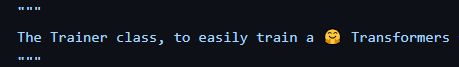

In [ ]:
tokenizer.decode(*batch["input_ids"].tolist())

'<s>A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it anyway!'

In [ ]:
# raise NotImplemented("Your task: iteratively train the model to reduce loss using prompt optimizer (opt)")
num_epochs = 50
# Цикл обучения
for epoch in range(num_epochs):
    outputs = model_peft(input_ids = batch['input_ids'][:,  :3])
    next_word_logits = outputs.logits[:,  :, :]
    true_next_tokens = batch['input_ids'][:, :]
    loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

    loss.backward()
    opt.step()
    opt.zero_grad()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

assert loss.item() <= 0.1
print("Good job!")

Epoch 1, Loss: 10.445606231689453
Epoch 2, Loss: 9.170230865478516
Epoch 3, Loss: 8.519038200378418
Epoch 4, Loss: 8.153373718261719
Epoch 5, Loss: 7.872995853424072
Epoch 6, Loss: 7.610445022583008
Epoch 7, Loss: 7.349504470825195
Epoch 8, Loss: 7.085123538970947
Epoch 9, Loss: 6.815591335296631
Epoch 10, Loss: 6.5433430671691895
Epoch 11, Loss: 6.268985271453857
Epoch 12, Loss: 5.981407642364502
Epoch 13, Loss: 5.6792144775390625
Epoch 14, Loss: 5.3696064949035645
Epoch 15, Loss: 5.048090934753418
Epoch 16, Loss: 4.711451530456543
Epoch 17, Loss: 4.370656490325928
Epoch 18, Loss: 4.026202201843262
Epoch 19, Loss: 3.6774470806121826
Epoch 20, Loss: 3.3397700786590576
Epoch 21, Loss: 3.0236172676086426
Epoch 22, Loss: 2.734041213989258
Epoch 23, Loss: 2.4839279651641846
Epoch 24, Loss: 2.258439779281616
Epoch 25, Loss: 2.0410208702087402
Epoch 26, Loss: 1.8302828073501587
Epoch 27, Loss: 1.6263258457183838
Epoch 28, Loss: 1.4281179904937744
Epoch 29, Loss: 1.238999605178833
Epoch 30, L

In [ ]:
prompt = 'A quick brown fox'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
batch['input_ids'] = torch.cat([space_for_prompts, batch['input_ids']], dim=1)
batch['attention_mask'] = torch.cat([torch.ones_like(space_for_prompts), batch['attention_mask']], dim=1)

In [ ]:
out = model_peft(**batch)

In [ ]:
tokenizer.decode(out.logits.argmax(2).reshape(1, -1)[0, :].cpu().numpy().tolist())

'<s> A quick brown fox did not jump over the lazy dog. Besides, that dog deserved<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>beeldMT\n\n\nAnchor'

### Parameter-efficient finetuning with LoRA (2 points)

When training on more serious tasks, you can use low-rank adapters based on the [LoRA paper](https://arxiv.org/pdf/2106.09685.pdf).

The core idea is to add low-rank adapters __in parallel with existing linear layers,__ like this:
<center><img src="https://i.imgur.com/6bQLNiG.png" width=240px></center>

In the original LoRA paper, the adapters were only added to attention projection matrices. However, [subsequent works](https://arxiv.org/abs/2305.14314) show that it is useful to adapt FFNs as well. But before we do any training, we need to implement the basic LoRA layer.

In [ ]:
# re-load the model to remove any previous PEFT tuners
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name, device_map='auto', low_cpu_mem_usage=True, offload_state_dict=True,
    load_in_4bit=True, torch_dtype=torch.float32,  # weights are 4-bit; layernorms and activations are fp32
)
for param in model.parameters():
    param.requires_grad=False
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
class LoRALayer(nn.Module):
    """Wraps a linear layer with LoRA-like adapter. Wraps an existing OPT linear layer"""
    def __init__(self, module: nn.Linear, rank: int):
        super().__init__()
        self.module = module  # pre-trained (frozen) linear layer
        self.adapter_A = nn.Parameter(torch.empty(module.in_features, rank, device=module.weight.device))
        nn.init.kaiming_uniform_(self.adapter_A, a=5 ** 0.5)
        self.adapter_B = nn.Parameter(torch.zeros(rank, module.out_features, device=module.weight.device))

    def forward(self, input):
        # Apply self.module and LoRA adapter, return the sum (self.module outputs + adapter outputs)
        adapter_output = torch.matmul(input, self.adapter_A)  # LoRA adapter A
        adapter_output = torch.matmul(adapter_output, self.adapter_B)  # LoRA adapter B
        return self.module(input) + adapter_output

In [ ]:
# test your implementation
test_linear = nn.Linear(128, 128)
test_linear.weight.data[...] = torch.eye(128)
test_adapter = LoRALayer(test_linear, rank=8)

assert torch.allclose(test_adapter(torch.ones(1, 1, 128)), test_linear.bias + 1), "please check your forward pass"

test_adapter.adapter_A.data[...] = torch.linspace(0.1, -0.5, 128 * 8).view(128, 8)
test_adapter.adapter_B.data[...] = torch.linspace(0.5, -0.1, 128 * 8).view(8, 128)
test_linear.bias.data[...] = torch.linspace(1., -1., 128)

dummy_loss = F.mse_loss(test_adapter(torch.ones(1, 128) / 128).squeeze(), torch.linspace(-1, 1, 128))
assert torch.allclose(dummy_loss, torch.tensor(1.3711389), rtol=0, atol=1e-4)
dummy_loss.backward()
assert all(w.grad is not None for w in [test_adapter.adapter_A, test_adapter.adapter_B]), "some adapter weights have no grad"
assert torch.allclose(test_adapter.adapter_A.grad.sum(), torch.tensor(-0.60158), rtol=0, atol=1e-4), "bad grad w.r.t. A"
assert torch.allclose(test_adapter.adapter_B.grad.sum(), torch.tensor(0.9931), rtol=0, atol=1e-4), "bad grad w.r.t. B"
# note: bad grad means that your code is different from LoRA paper OR that your code is not autograd-friendly (e.g. no_grad)
del dummy_loss, test_linear, test_adapter
print("All tests passed!")

All tests passed!


### Apply LoRA to the model

The code below applies LoRA adapters on top of Q/K/V linear layers in Llama attention. You may also choose to modify other layers:
* self_attn.o_proj - attention output projection
* mlp.up_proj, mlp.gate_proj, mlp.down_proj - transformer feedforward layers
* lm_head - output LM head

__Note:__ please scroll down for the homework task

In [ ]:
lora_rank = 8

for name, module in model.model.layers.named_modules():
    if 'LlamaDecoderLayer' in repr(type(module)):
        module.self_attn.q_proj = LoRALayer(module.self_attn.q_proj, rank=lora_rank).to(device)
        module.self_attn.k_proj = LoRALayer(module.self_attn.k_proj, rank=lora_rank).to(device)
        module.self_attn.v_proj = LoRALayer(module.self_attn.v_proj, rank=lora_rank).to(device)

assert sum(isinstance(module, LoRALayer) for module in model.modules()) == 96  # for Llama-7B

In [ ]:
batch = tokenizer("This model wants to share its greatest secret:", return_tensors='pt', return_token_type_ids=False)
# test a single training step, make sure we get meaningful gradients
with torch.cuda.amp.autocast(dtype=torch.float32):
    out = model.forward(**batch)
    (out.logits.norm() / 100).backward()

for i, module in enumerate(model.modules()):
    if isinstance(module, LoRALayer):
        assert module.adapter_B.grad is not None
        assert module.adapter_B.grad.norm().item() > 0

model.zero_grad(set_to_none=True)
print("Grad check successful, well done!")

Grad check successful, well done!


### (example) How to train your model

The example below shows how to train the LoRA adapters on a dummy dataset. You will need to run a _similar_ training task later.

__Note:__ please scroll down for the homework task

In [ ]:
# checking if the model can learn. Change max_steps for proper training
import datasets
data = datasets.load_dataset("Abirate/english_quotes", split="train[:32]") # 32 lines
data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)
model._hf_peft_config_loaded = True  # silence a warning from HF trainer

trainer = transformers.Trainer(
    model=model, train_dataset=data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=2, gradient_accumulation_steps=1,
        # note: if you want larger batch size, increase gradient_accumulation_steps
        warmup_steps=250, max_steps=100, learning_rate=2e-4, fp16=True,
        logging_steps=1, output_dir='outputs', report_to=None),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
# if you see cache warnings, set `model.config.use_cache = False` to silence them. Please re-enable for inference!

trainer.train()

# NOTE: this is just an example! you do not have to wait for this progressbar to finish :)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,1.891200
2,1.696000
3,0.896900
4,1.745800
5,1.170200
6,0.734100
7,1.537300
8,1.084800
9,0.677200
10,1.449300


TrainOutput(global_step=100, training_loss=0.5476762482523918, metrics={'train_runtime': 163.4886, 'train_samples_per_second': 1.223, 'train_steps_per_second': 0.612, 'total_flos': 621258424123392.0, 'train_loss': 0.5476762482523918, 'epoch': 6.25})

### Final task: *actually* train the model (4 points)

Your task is to fine-tune the model to _generate python code_. Please use the above examples for inspiration. More specifically,

* __dataset:__ use [codeparrot-clean](https://huggingface.co/datasets/codeparrot/codeparrot-clean) or any other data containing python code. Since you do not need much data for this excercise, it is enough to use just shorter validation subset of `codeparrots`
* __preprocessing:__ select python code based on file extentions (.py)  (may skip in case of codeparrot - it is 100% python)
* __short lines:__ please take the first 512 characters of each line
* __adapter type:__ please use LoRA as defined above __plus at least one of:__
   - extra adapter on lm_head
   - extra adapter on MLP components (mlp.*)
   - trainable input embeddings (requires tweaking memory usage)

* __training:__ you do not have to train to convergence. If all goes well, your model should `.generate` code after 500 steps. Please use batch size of at least 4 (4 x 1 x 512 tokens) using `gradient_accumulation_steps=4`.


Note: the peft library also has LoRA implementation. However, we ask that for this assignment you show at least one complete training run with your own LoRA code.

__Alternative assignment:__ Instead of doing python code, feel free to substitute the task with any other dataset, e.g. your favorite artist or podcast, as long as it's ethical. If you choose your own task, please show examples of what your model learned - or did not learn, akin to the code examples below.

In [ ]:
!pip install --quiet transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 peft==0.5.0 bitsandbytes==0.41.2.post2

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from tqdm.auto import tqdm, trange
assert torch.cuda.is_available(), "you need cuda for this part"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 25.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB

In [ ]:
model_name = 'Enoch/llama-7b-hf'

# loading Llama tokenizer ...
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

# ... and the model itself
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name, device_map='auto', low_cpu_mem_usage=True, offload_state_dict=True,
    load_in_4bit=True, torch_dtype=torch.float32,  # weights are 4-bit; layernorms and activations are fp32
)
for param in model.parameters():
    param.requires_grad=False

model.gradient_checkpointing_enable()  # only store a small subset of activations, re-compute the rest.
model.enable_input_require_grads()     # override an implementation quirk in gradient checkpoints that disables backprop unless inputs require grad
# more on gradient checkpointing: https://pytorch.org/docs/stable/checkpoint.html https://arxiv.org/abs/1604.06174

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
from datasets import load_dataset

dataset = load_dataset("codeparrot/codeparrot-clean")

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
prompts =  ['', 'import', 'from', 'while', 'try', 'if', 'for', 'torch']  # feel free to add a few more that are not 100% assiciated with Python

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./finetuned_model",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    save_total_limit=1,
)

# Create Trainer and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,  # Replace with your training dataset
)

# Train the model
trainer.train()

rows = []

for prompt in prompts:
    # Generate code samples using the trained model
    generated_code = model.generate(
        tokenizer(prompt, return_tensors="pt").input_ids,
        max_length=512,
        num_beams=5,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        repetition_penalty=1.0,
        length_penalty=1.0,
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode the generated code
    decoded_code = tokenizer.decode(generated_code[0], skip_special_tokens=True)

    # Add the results to the table
    rows.append(row_template.format(prompt, "BEFORE FINETUNING", decoded_code))

# Display the results using HTML
display(HTML(table_template.format('\n'.join(rows))))

In [ ]:
# This template helps to compare generated code samples in pretty table form
# feel free to present your work in other forms

from IPython.display import HTML, display
table_template = """<table style="border:1px solid black" >
  <tr>
    <th style="text-align: center; border:1px solid black">PROMPT</th>
    <th style="text-align: center; border:1px solid black">BEFORE</th>
    <th style="text-align: center; border:1px solid black">AFTER</th>
  </tr>
{}
</table>"""

row_template = '''  <tr>
    <td style="width:20%; border:1px solid black"><pre align="left">`{}`</pre></td>
    <td style="width:40%; border:1px solid black"><pre align="left">{}</pre></td>
    <td style="width:40%; border:1px solid black"><pre align="left">{}</pre></td>
  </tr>'''

rows = []

for prompt in prompts:
    # replace placeholders in the format() arguments
    rows.append(row_template.format(prompt, "BEFORE FINETUNING", "TO BE GENERATED AFTER FINETUNING"))

display(HTML(table_template.format('\n'.join(rows))))

PROMPT,BEFORE,AFTER
``,BEFORE FINETUNING,TO BE GENERATED AFTER FINETUNING
`import`,BEFORE FINETUNING,TO BE GENERATED AFTER FINETUNING
`from`,BEFORE FINETUNING,TO BE GENERATED AFTER FINETUNING
`while`,BEFORE FINETUNING,TO BE GENERATED AFTER FINETUNING
`try`,BEFORE FINETUNING,TO BE GENERATED AFTER FINETUNING
`if`,BEFORE FINETUNING,TO BE GENERATED AFTER FINETUNING
`for`,BEFORE FINETUNING,TO BE GENERATED AFTER FINETUNING
`torch`,BEFORE FINETUNING,TO BE GENERATED AFTER FINETUNING


If you reach this: congratulations! you've completed everything in this practice session.

If you want to dig deeper, try to implement prompt-tuning (for bonus points!).
You can read more about prompt tuning variants in paper [1](https://arxiv.org/abs/2104.08691) or paper [2](https://arxiv.org/abs/2101.00190). Both versions can be implemented by passing trainable prompts as `model.forward(..., past_key_values=your_prompts)`.



### Read more

* How post-training quantization works: https://arxiv.org/abs/2208.07339
* An overview of running large models: https://huggingface.co/docs/accelerate/package_reference/big_modeling
* A general library for different adapter types: https://adapterhub.ml/


### [extra info] Running other models.

This notebook's code can run with other models of similar size, such as [Falcon-7B](https://huggingface.co/tiiuae/falcon-7b), [OPT-6.7B](https://huggingface.co/facebook/opt-6.7b) or [BLOOM-7.1B](https://huggingface.co/bigscience/bloom-7b1). However, they will require minor code tweaks:
1. change the model name in `AutoModelForCausalLM.from_pretrained()` __and__ `AutoTokenizer`
2. In the prompt tuning code, change `model.model.embed_tokens` to refer to the target model's word embeddings. Simply `print(model)` to navigate to them.
3. Change code to add Lora layers - specifically where you what the transformer block components, since those components now have different names.